In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
from math import ceil
from pathlib import Path
from matplotlib.colors import LogNorm
import yaml
from waveforms_module.make_waveform import BatchedLightSimulation, mod0_sampler
from tqdm import tqdm, trange

import sys
sys.path.append('/sdf/home/c/carsmith/flash_reconstruction/siren-lartpc')
sys.path.append('..')

### First, instantiate a simulator instance.

In [2]:
device = torch.device('cuda:0')

sim = BatchedLightSimulation(cfg="templates/waveform_sim.yaml").to(device)

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001                     # us
	LIGHT_WINDOW: [1, 10]


### Reconfiguring simulation properties

Default values:
```
NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
NOMINAL_TAU_S: 0.001                       # us
NOMINAL_TAU_T: 1.530                       # us
NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
```

In [33]:
params = dict()

params['singlet_fraction'] = 1
params['light_oscillation_period'] = 0.11
params['light_response_time'] = 0.055
params['tau_s'] = 0.001
params['tau_t'] = 1.530
params['light_gain'] = -45.0
params['tpb_tau'] = 0.002 # 2 ns
params['light_tick_size'] = 0.001 # 1 ns
params['offset'] = 3000 # ns

# Check it is updated
sim.reconfigure(params)
print(sim.singlet_fraction)

1


### Use `gen_waveform` in `precise` mode to generate an input of 10 photons per pmt

Waveform shape: torch.Size([128, 80000])


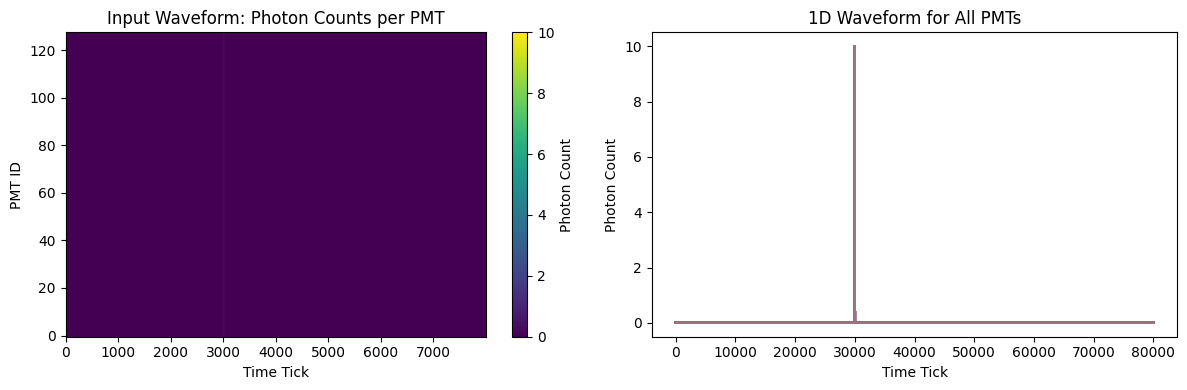

In [34]:
pmt_ids = torch.arange(128)
arrival_times = torch.zeros(128, dtype=torch.int64)
wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, nphotons=10)
downsampled_wf = sim.downsample_waveform(wf.unsqueeze(0))
print(f"Waveform shape: {wf.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Left plot: 2D waveform image from downsampled_wf
im = ax1.imshow(downsampled_wf.squeeze(0), aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines from wf
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)
for i in range(n_pmts):
    ax2.plot(ticks, wf[i], alpha=0.5)
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs")

plt.tight_layout()
plt.show()

### Run simulator with stochastic scintillation & larnd-sim electronics convolution.
* Stochastic scintillation delay sampling includes prompt and delayed light with fractions specificed by configurable `sim.singlet_fraction`

`sim` forward accepts following parameters:
- `timing_dist`: input timing distribution of shape `[# in batch, # pmts, # time ticks]`
- `scintillation` (`bool`, optional): include stochastic scintillation delay (default is `True`)
- `tpb_delay` (`bool`, optional): include stochastic tpb delay (default is `False`)

Output shape: (128, 8000)


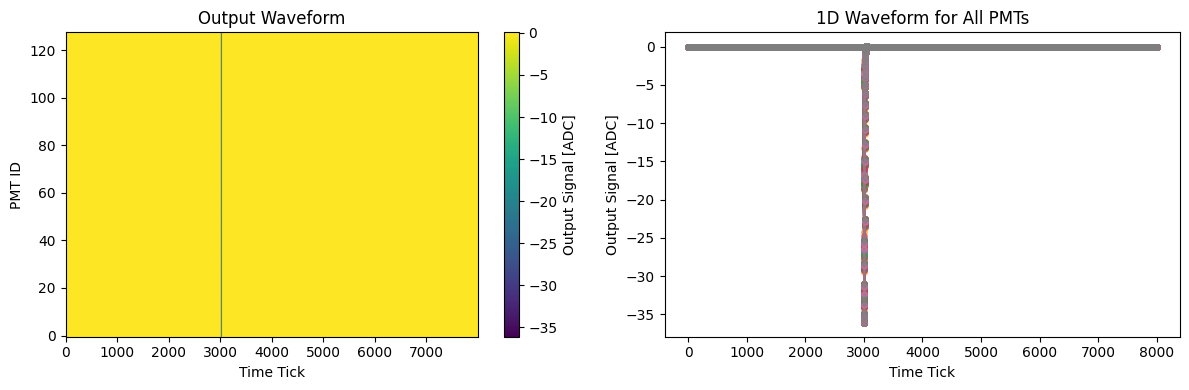

In [35]:
output, scint_delays = sim(wf.to(device))
output = output.detach().cpu().numpy()
print(f"Output shape: {output.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 2D timing histogram
im = ax1.imshow(output, aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Output Waveform")

cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Output Signal [ADC]")

# 1D waveform per pmt
ticks = np.arange(output.shape[1])
for i in range(n_pmts):
    ax2.plot(ticks, output[i], marker = 'o', markersize=4, alpha=0.5, label=i)
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Output Signal [ADC]")
ax2.set_title("1D Waveform for All PMTs")
plt.tight_layout()
plt.show()

In [36]:
# Checking that waveform starts exactly at 0 (or some offset)
# for all channels, get first nonzero value
print(output.shape)
mask = output< -0.001
selected_values = output[mask]
masked_output = output.copy()  # avoid modifying original
masked_output[~(output < -0.001)] = 0

print("signal starts at index: ", np.argmax(masked_output != 0))
print("it should start at: ", 2560 / 16)

(128, 8000)
signal starts at index:  3000
it should start at:  160.0


BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]
sirentv output shape: (128, 5000)
1
1
aligned waveform shapes: (5000,), (5000,)


Text(0.5, 1.0, '1D Waveform for PMT 40 with Scint. Sampling')

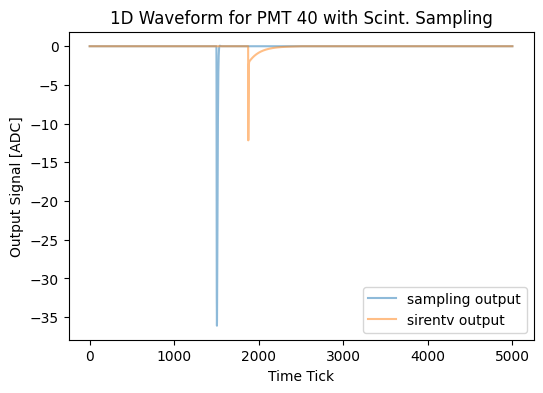

In [37]:
from sirentv.sirentv.waveform import BatchedLightSimulation

sim_sirentv = BatchedLightSimulation(cfg="../sirentv/templates/waveform_sim.yaml").to(device)
sirentv_output = sim_sirentv(wf.to(device))
sirentv_output = sirentv_output.detach().cpu().numpy()
print(f"sirentv output shape: {sirentv_output.shape}")

# strategy for aligning them
def align_waveforms(wf1: torch.Tensor, wf2: torch.Tensor, pad_start: int = 30, pad_end: int = 10):
    '''
    Lining them up, given 2 waveforms of shape (16000)
    - first, identify where waveform becomes nonzero
    - crop to start 30 ticks earlier
    - then, identify where waveform becomes zero again
    - crop to end 10 ticks later
    '''
    def crop_waveform(wf: torch.Tensor):
        nonzero_indices = (wf > 1e-8).nonzero()
        print(len(nonzero_indices))
        if len(nonzero_indices) == 0:
            return wf  # return as-is if entirely zero
        start_idx = max(nonzero_indices[0][0] - pad_start, 0)
        end_idx = min(nonzero_indices[0][-1] + pad_end + 1, wf.shape[0])
        return wf[start_idx:end_idx]

    cropped_wf1 = crop_waveform(wf1)
    cropped_wf2 = crop_waveform(wf2)

    # choose longest one
    # crop it to match shorter one by taking evenly off both sides
    len1 = cropped_wf1.shape[0]
    len2 = cropped_wf2.shape[0]

    if len1 > len2:
        diff = len1 - len2
        start = diff // 2
        end = start + len2
        cropped_wf1 = cropped_wf1[start:end]
    elif len2 > len1:
        diff = len2 - len1
        start = diff // 2
        end = start + len1
        cropped_wf2 = cropped_wf2[start:end]
    
    return cropped_wf1, cropped_wf2

# Pick one PMT waveform to inspect up close
aligned_wf1, aligned_wf2 = align_waveforms(output[40], sirentv_output[40])
print(f"aligned waveform shapes: {aligned_wf1.shape}, {aligned_wf2.shape}")
ticks = np.arange(aligned_wf1.shape[0])
# ticks = np.arange(150, 250)

plt.figure(figsize=(6, 4))
plt.plot(ticks, aligned_wf1, alpha=0.5, label='sampling output')
plt.plot(ticks, aligned_wf2, alpha=0.5, label='sirentv output')
plt.xlabel("Time Tick")
plt.ylabel("Output Signal [ADC]")
plt.legend()
plt.title("1D Waveform for PMT 40 with Scint. Sampling")

### Adding new sampling modes to `gen_waveform`

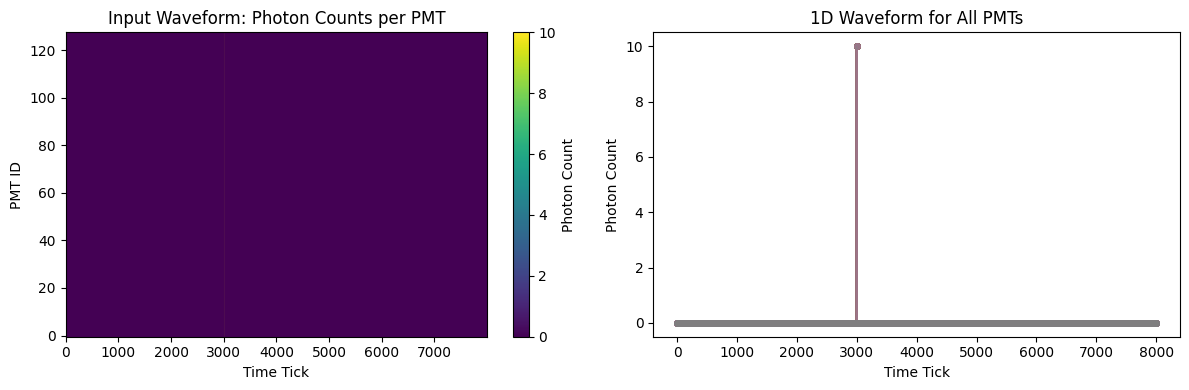

Output shape: (128, 8000)


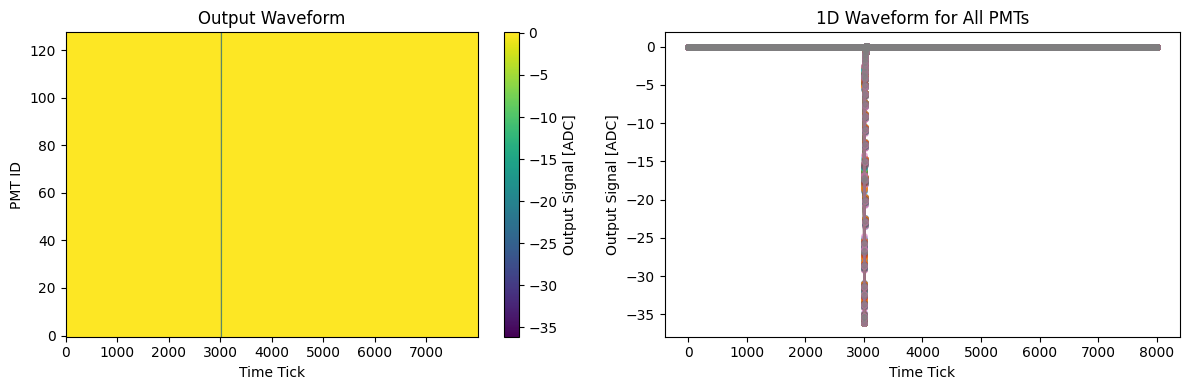

In [38]:
# def gen_waveform_gaussian(self, pmt_ids: torch.Tensor, nphotons: torch.Tensor, arrival_mean:float=0.0, std:float=1.0, n_pmts:int=129):

# Precise mode: 10 photons per pmt 
pmt_ids = torch.arange(128)
arrival_times = torch.zeros(128, dtype=torch.int64)
precise_wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, nphotons=10)
precise_wf_downsample = sim.downsample_waveform(precise_wf.unsqueeze(0))
precise_wf_downsample = precise_wf_downsample.squeeze(0)

# Gaussian sampling mode: 50 photons per pmt
nphotons = torch.full((128,), 50)
gaussian_wf = sim.gen_waveform(mode='gaussian', pmt_ids=pmt_ids, nphotons=nphotons)
gaussian_wf_downsample = sim.downsample_waveform(gaussian_wf.unsqueeze(0))
gaussian_wf_downsample = gaussian_wf_downsample.squeeze(0)

wf = precise_wf_downsample

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
# Left plot: 2D waveform image  
im = ax1.imshow(wf, aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)
for i in range(n_pmts):
    ax2.plot(ticks, wf[i], marker='o', markersize=4, alpha=0.5)
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs")
plt.tight_layout()
plt.show()

output, scint_delays = sim(precise_wf.to(device))
output = output.detach().cpu().numpy()
print(f"Output shape: {output.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 2D timing histogram
im = ax1.imshow(output, aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Output Waveform")

cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Output Signal [ADC]")

# 1D line plot
ticks = np.arange(output.shape[1])
for i in range(n_pmts):
    ax2.plot(ticks, output[i], marker = 'o', markersize=4, alpha=0.5, label=i)
    # ax2.scatter(ticks, output[i], marker = 'o', label=i)
    # print(i, np.argmin(output[i]))
# ax2.plot(np.sum(output, axis=0), color='black')
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Output Signal [ADC]")
ax2.set_title("1D Waveform for All PMTs")
# plt.legend()
plt.tight_layout()
plt.show()

### Now, we look at modeling a time delay from the TPB Wavelength Shifter

sum of normed pdf × bin widths: 1.0


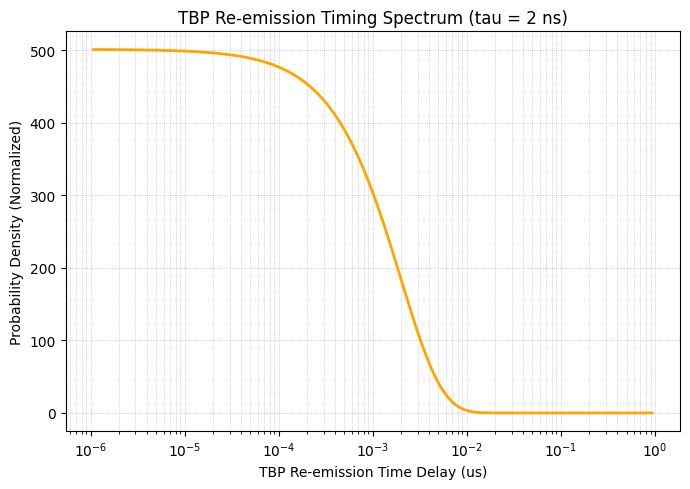

In [39]:
# Plotting the re-emission timing distribution we would like to sample from
# Define bins
bin_edges = np.geomspace(1e-6, 1, 100)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Compute scaled theoretical PDF
tau = 0.002 # re-emission lifetime of 2 nanoseconds
pdf_emission = (1 / tau) * np.exp(-bin_centers / tau)
pdf_integral = np.sum(pdf_emission * bin_widths)

norm_pdf = pdf_emission / pdf_integral
print('sum of normed pdf × bin widths:', np.sum(norm_pdf * bin_widths))

plt.figure(figsize=(7, 5))
plt.plot(bin_centers, norm_pdf, color='orange', lw=2)

plt.xscale('log')
plt.xlabel('TBP Re-emission Time Delay (us)')
plt.ylabel('Probability Density (Normalized)')
plt.title('TBP Re-emission Timing Spectrum (tau = 2 ns)')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

Output shape: (128, 8000)


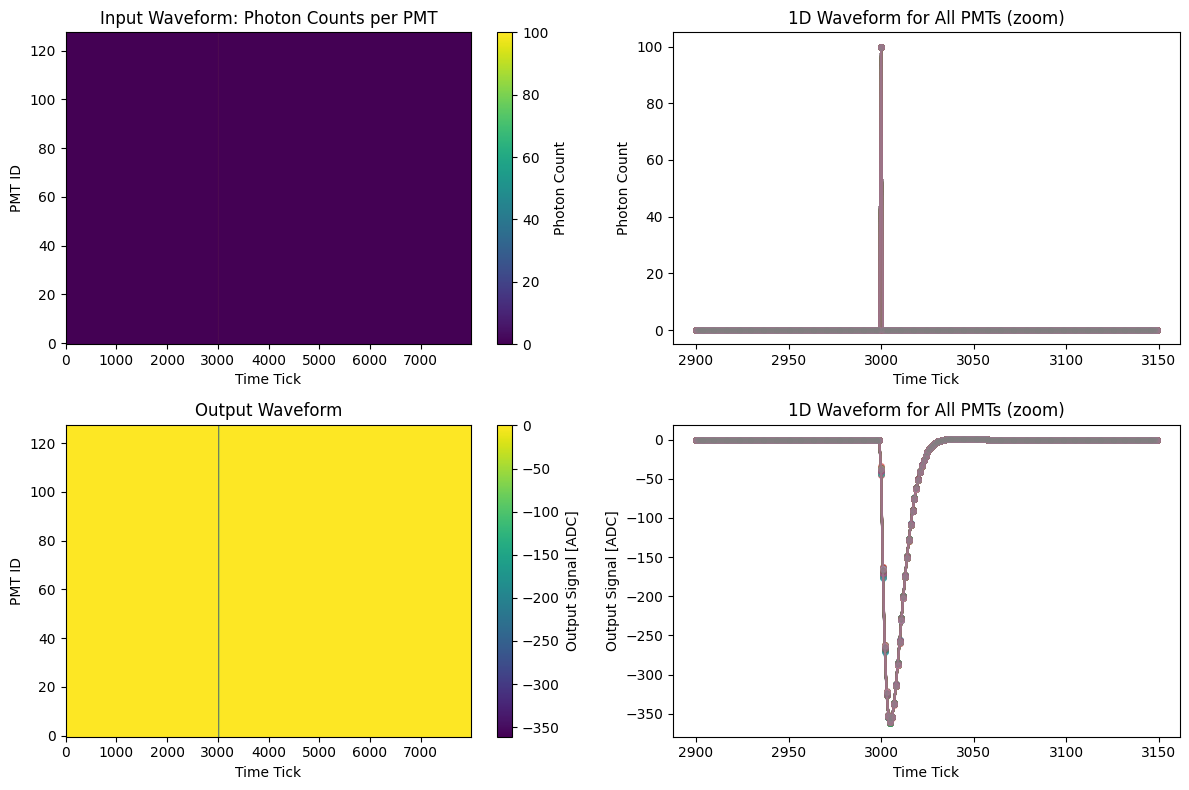

In [45]:
# Precise mode: 100 photons per pmt 
pmt_ids = torch.arange(128)
arrival_times = torch.zeros(128, dtype=torch.int64)
precise_wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, nphotons=100)
precise_wf_downsample = sim.downsample_waveform(precise_wf.unsqueeze(0))
precise_wf_downsample = precise_wf_downsample.squeeze(0)

wf = precise_wf_downsample

output, scint_delays = sim(precise_wf.to(device), tpb_delay=True)
output = output.detach().cpu().numpy()
print(f"Output shape: {output.shape}")

############### Plotting ############################

fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 row, 2 columns
ax1, ax2, ax3, ax4 = axs.flatten()

# Left plot: 2D waveform image  
im = ax1.imshow(wf, aspect='auto', origin='lower')
ax1.set_xlabel("Time Tick")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)
for i in range(n_pmts):
    ax2.plot(ticks[2900:3150], wf[i][2900:3150], marker='o', markersize=4, alpha=0.5)
ax2.set_xlabel("Time Tick")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs (zoom)")

# Bottm left: 2D timing histogram
im = ax3.imshow(output, aspect='auto', origin='lower')
ax3.set_xlabel("Time Tick")
ax3.set_ylabel("PMT ID")
ax3.set_title("Output Waveform")

cbar = fig.colorbar(im, ax=ax3)
cbar.set_label("Output Signal [ADC]")

# Bottom right: 1D line plot
ticks = np.arange(output.shape[1])
for i in range(n_pmts):
    ax4.plot(ticks[2900:3150], output[i][2900:3150], marker = 'o', markersize=4, alpha=0.5, label=i)
ax4.set_xlabel("Time Tick")
ax4.set_ylabel("Output Signal [ADC]")
ax4.set_title("1D Waveform for All PMTs (zoom)")
plt.tight_layout()
plt.show()